In [1]:
!pip install tf-nightly #텐서플로우 설치?하기

     |████████████████████████████████| 403.7MB 39kB/s 
     |████████████████████████████████| 4.0MB 49.8MB/s 
     |████████████████████████████████| 4.0MB 49.9MB/s 
     |████████████████████████████████| 471kB 57.0MB/s 
     |████████████████████████████████| 5.9MB 51.4MB/s 
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.4.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement grpcio~=1.32.0, but you'll have grpcio 1.34.1 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement h5py~=2.10.0, but you'll have h5py 3.1.0 which is incompatible.
  Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10.0
  Found existing installation: grpcio 1.32.0
    Uninstalling grpcio-1.32.0:
      Successfully uninstalled grpcio-1.32.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3


## TensorFlow 및 기타 라이브러리 가져오기

In [2]:
import matplotlib.pyplot as plt #그리기
import numpy as np #잘 아는 넘파이~
import os #내 컴퓨터의 디렉토리나 경로, 파일 등을 활용하게 도와주는 모듈! path와 같이 많이 쓰인다
import PIL #파이썬에서 이미지를 처리하고 핸들링하기 위해서 사용. 여기서 가장 중요하게 쓰이는건 image 메소드?
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers #레이어 쌓기
from tensorflow.keras.models import Sequential #모델 만들기

## 데이터세트 다운로드 및 탐색하기

In [3]:
import pathlib
#파일 경로를 문자열이 아닌 객체로 처리하는 것! 음.. 잘 모르겠군^^
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 2s 0us/step


In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
# glob는 파일들의 목록을 뽑을 때 사용하는데, 파일의 경로명을 반환 받을 수 있다.
#여기서는 그냥 이미지 개수라서 앞에 이름은 상관없이 끝에 jpg로 끝나는 모든 
#파일들의 개수를 세어 준 것 같다.
print(image_count)

3670


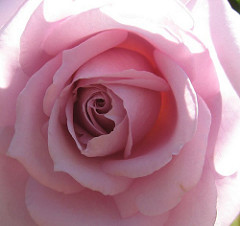

In [5]:
roses = list(data_dir.glob('roses/*')) #장미 불러오기
PIL.Image.open(str(roses[0])) #장미 사진들중에 첫 번째 사진을 여는데 str()은 해당 객체를 읽을 수 있도록 사용자를 위한 함수이다

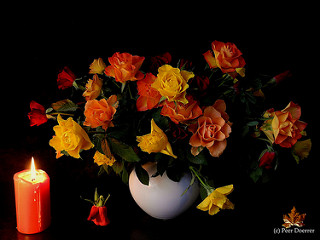

In [6]:
PIL.Image.open(str(roses[1]))

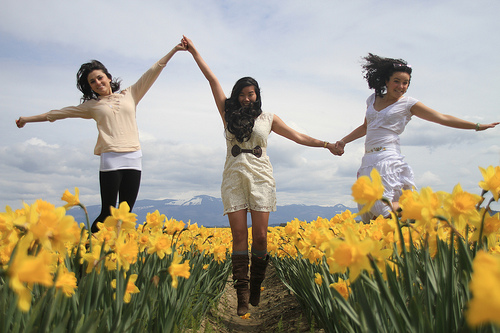

In [7]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

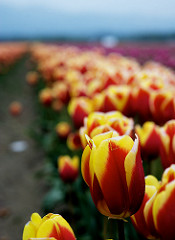

In [8]:
PIL.Image.open(str(tulips[1]))

In [9]:
batch_size = 32
img_height = 180
img_width = 180
#이미지 크기 지정, batch size는 몇개씩 묶어서 학습할 것인지~

In [10]:
#훈련, 검증 데이터 불러오기
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,#디렉터리 경로
  validation_split=0.2,#검증분할! test와는 다른 것. train set에서 나눠주는 것
  subset="training",
  seed=123,#seed고정
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [11]:
#동일
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [12]:
class_names = train_ds.class_names #train_dataset에 있는 class_names 속성에서 클래스 이름을 찾을 수 있지. 얘네는 디렉토리 이름에 해당.
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


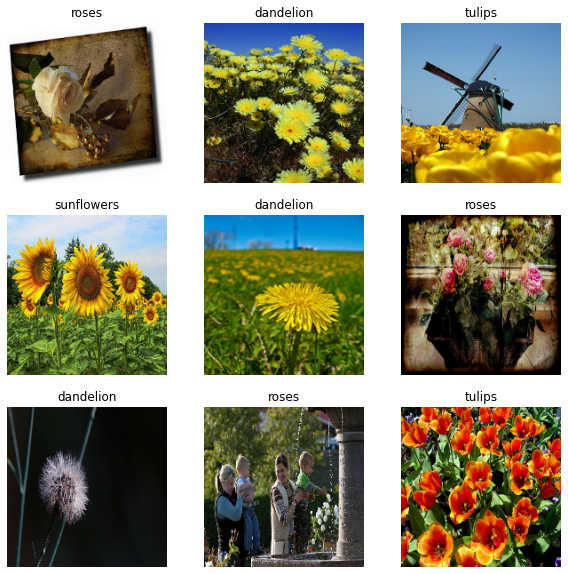

In [13]:
import matplotlib.pyplot as plt #그려보자

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1) #사진이 가로세로 3장씩 들어가고 for문 돌면서 자리 하나씩 옆으로!
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]]) #해당 i의 label을 이미지의 타이틀로
    plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

#180x180x3 형상의 32개 이미지 묶음으로 되어 있다. 마지막 차원 3은 RGB를 나타냄
#label_batch는 32개 이미지에 해당하는 레이블

(32, 180, 180, 3)
(32,)


Dataset.cache()는 첫 epoch 동안 디스크에서 이미지를 로드한 후 이미지를 메모리에 유지합니다. 이렇게 하면 모델을 훈련하는 동안 데이터세트가 병목 상태가 되지 않습니다. 데이터세트가 너무 커서 메모리에 맞지 않는 경우, 이 메서드를 사용하여 성능이 높은 온디스크 캐시를 생성할 수도 있습니다.

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
#AUTOTUNE 옵션을 선언해서 Tensorflow.data 런타임이 코드를 실행할 때 동적으로 값을
#조정해서 편리하게 이미지를 훈련할 수 있음.
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
#prefetch를 적용하면 gpu가 훈련하는 동시에 cpu가 다음 image_batch를 적재함

In [16]:
#rgb채널 값은 [0,255] 범위에 있기 때문에 255로 나눠줘서 값이 [0,1]에 있도록 표준화
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)


In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


In [18]:
num_classes = 5 #클래스 개수 5개지
#모델 쌓기
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  #2d에 대한 컨볼루션, 16개의 3크기의 필터, 제로패딩 시행, 활성화 함수 relu를 통해 양의 feature을 더 선명하게!
  layers.MaxPooling2D(),#맥스풀링으로 가장 큰 값을 뽑아내기
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),#Dense 레이어에 넣어주기 위해 일차원 배열로 만들어주기
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [19]:
model.compile(optimizer='adam', #최적화 함수는 아담
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              #손실함수
              metrics=['accuracy']#각 훈련에 대한 검증 정확성 accuracy)

In [20]:
model.summary() #summary 함수를 통해 각 레이어를 보여줌

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [21]:
epochs=10 #모델 훈련하기! 10번 반복
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 75s 811ms/step - loss: 1.4503 - accuracy: 0.3689 - val_loss: 1.0238 - val_accuracy: 0.5886
Epoch 2/10
92/92 [==============================] - 73s 790ms/step - loss: 0.9859 - accuracy: 0.6072 - val_loss: 0.9707 - val_accuracy: 0.6076
Epoch 3/10
92/92 [==============================] - 73s 798ms/step - loss: 0.8129 - accuracy: 0.6794 - val_loss: 0.8746 - val_accuracy: 0.6717
Epoch 4/10
92/92 [==============================] - 73s 795ms/step - loss: 0.6230 - accuracy: 0.7680 - val_loss: 0.9564 - val_accuracy: 0.6281
Epoch 5/10
92/92 [==============================] - 74s 802ms/step - loss: 0.4371 - accuracy: 0.8417 - val_loss: 0.9921 - val_accuracy: 0.6703
Epoch 6/10
92/92 [==============================] - 73s 794ms/step - loss: 0.2339 - accuracy: 0.9290 - val_loss: 1.1685 - val_accuracy: 0.6662
Epoch 7/10
92/92 [==============================] - 73s 797ms/step - loss: 0.1339 - accuracy: 0.9604 - val_loss: 1.3432 - val_accuracy: 0.6608

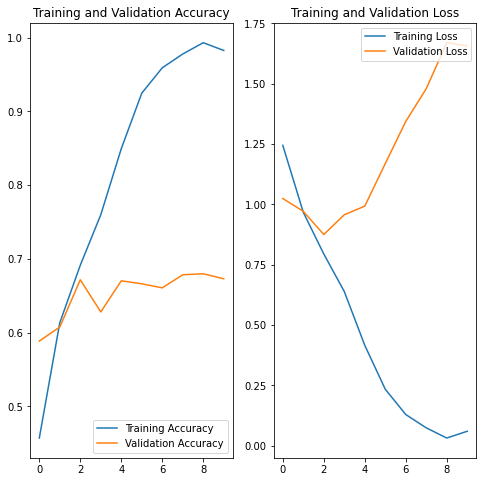

In [22]:
#손실, 정확성을 한눈에 보기 위해 plot 생성하기
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs) #범위는 전체 에폭

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1) #첫 번째 그래프
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)#두 번째 그래프
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
#training set과 val set에 대한 정확성은 큰 차이가 있는 것으로 보임
#val set에서 낮은 성능을 보인다

 또한 훈련 정확성과 검증 정확성 간의 정확성 차이가 상당 -> 과대적합의 징후

훈련 예제가 적을 때 모델은 새로운 예제에서 모델의 성능에 부정적인 영향을 미치는 정도까지 훈련 예제의 노이즈나 원치 않는 세부까지 학습한다 -> 과대적합

여기서 과대적합을 막기 위해서 -> 데이터 증강(data augmentation)과 drop out실행


데이터 증강은 증강한 다음 믿을 수 있는 이미지를 생성하는 임의 변환을 사용하는 방법으로 기존 예제에서 추가 훈련 데이터를 생성하는 접근법을 취한다. 그러면 모델이 데이터의 더 많은 측면을 파악하게 되므로 일반화가 더 쉬워진다고 한다.

여기서는 실험적인 Keras 전처리 레이어를 사용하여 데이터 증강을 구현. 이들 레이어는 다른 레이어와 마찬가지로 모델 내에 포함될 수 있으며, GPU에서 실행.

In [23]:
#데이터 증강하기
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", #좌우반전 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),#0.1?0.1은 뭐지?
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

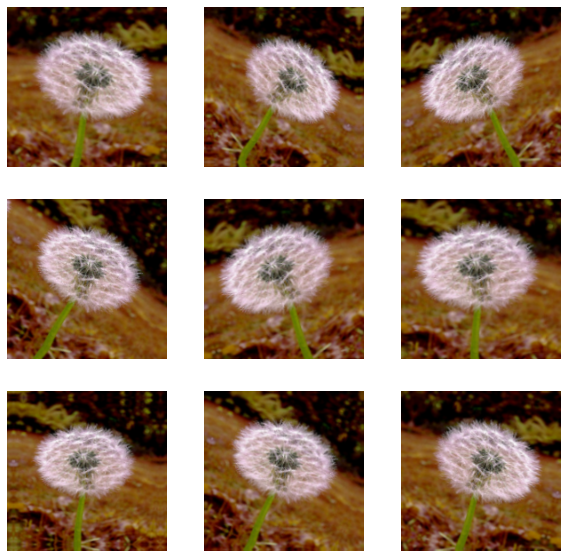

In [24]:
#증강한 데이터가 어떻게 보이나 보자! 시각화
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [25]:
#과대적합을 줄이기 위한 drop out을 레이어에 추가!
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [26]:
#동일하게 모델 컴파일
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [28]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
#이것도 오래걸린다 원래 안 이랬는데!

Epoch 1/15
92/92 [==============================] - 87s 937ms/step - loss: 1.4227 - accuracy: 0.3753 - val_loss: 1.0916 - val_accuracy: 0.5545
Epoch 2/15
92/92 [==============================] - 86s 934ms/step - loss: 1.0420 - accuracy: 0.5930 - val_loss: 0.9021 - val_accuracy: 0.6621
Epoch 3/15
92/92 [==============================] - 86s 931ms/step - loss: 0.8643 - accuracy: 0.6683 - val_loss: 0.8888 - val_accuracy: 0.6649
Epoch 4/15
92/92 [==============================] - 85s 924ms/step - loss: 0.8471 - accuracy: 0.6746 - val_loss: 0.8743 - val_accuracy: 0.6717
Epoch 5/15
92/92 [==============================] - 84s 917ms/step - loss: 0.7765 - accuracy: 0.7012 - val_loss: 0.8193 - val_accuracy: 0.6839
Epoch 6/15
92/92 [==============================] - 84s 916ms/step - loss: 0.7388 - accuracy: 0.7209 - val_loss: 0.8414 - val_accuracy: 0.6798
Epoch 7/15
92/92 [==============================] - 84s 908ms/step - loss: 0.7132 - accuracy: 0.7284 - val_loss: 0.7435 - val_accuracy: 0.6907

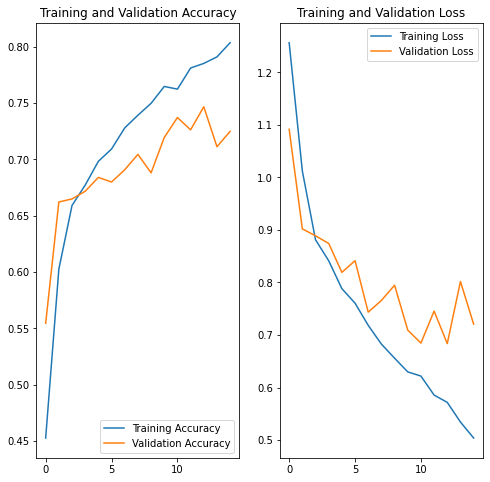

In [29]:
#위에서 해준 것 처럼 train set과 val set에서 정확도와 손실을 한눈에 확인하기 위해 시각화!
#과적합을 줄이기 위해 실행한 데이터 증강과 드롭아웃을 통해 성능이 얼마나 더 좋아졌는지 확인해보자
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [30]:
#지금까지 만든 모델을 사용하여 훈련, 검증 셋에 사용되지 않은 새로운! 이미지를 분류해보자
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)
#이미지 열어주고

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
) #load_img 이미지를 nxp 벡터(픽셀)로 나눈다. 
img_array = keras.preprocessing.image.img_to_array(img)
#img_to_array 는 이미지를 배열로 저장한다는 말! row,column,RGB의 배열로 저장됨.
#그림 조각마다 위치와 컬러가 저장된다는 의미
img_array = tf.expand_dims(img_array, 0) # expand_dims->배열 차원 늘리기
#tf.expand_dims(input,dim,name=None)
#dim은 input의 구조에서 어떤 차원 인덱스에 삽입할 것인지
#name은 오퍼레이션의 명칭(선택사항)
#input에는 늘려질 배열을 넣고 차원 인덱스 dim에 삽입함. dim은 0부터 시작

predictions = model.predict(img_array) #어떤 클래스에 들어갈지 예측!
score = tf.nn.softmax(predictions[0]) #softmax연산을 시행해줌

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
) # 잘 했다!

122880/117948 [===============================] - 0s 0us/step
This image most likely belongs to sunflowers with a 99.83 percent confidence.
